# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

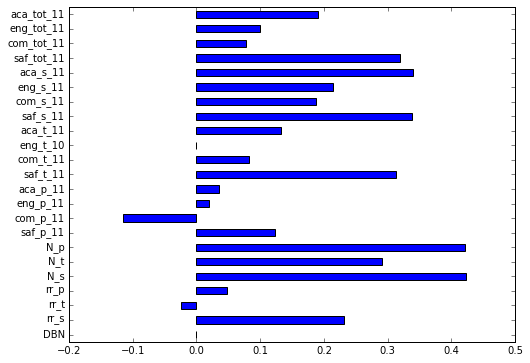

'\ncorrelated highly with sat_score : \n\nN_s  Number of student respondents\nN_t  Number of teacher respondents\nN_p  Number of parent respondents\n\naca_s_10  Academic expectations score based on student responses\nsaf_s_10  Safety and Respect score based on student responses\nsaf_t_10  Safety and Respect score based on teacher responses\n'

In [10]:
# Make a bar plot of the correlations between these fields and sat_score.

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
correlations = combined.corr()["sat_score"]
correlations[survey_fields].plot.barh()

plt.show()

'''
correlated highly with sat_score : 

N_s  Number of student respondents
N_t  Number of teacher respondents
N_p  Number of parent respondents

aca_s_10  Academic expectations score based on student responses
saf_s_10  Safety and Respect score based on student responses
saf_t_10  Safety and Respect score based on teacher responses
'''

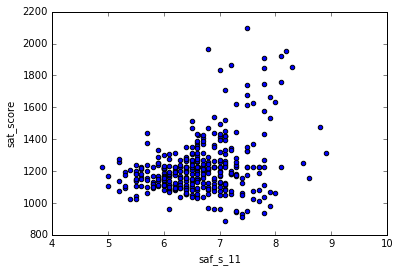

In [11]:
# Investigate safety scores.
# Make a scatter plot of the saf_s_11 column vs. the sat_score in combined.

combined.plot.scatter(x='saf_s_11', y='sat_score')
plt.show()

  school_dist  saf_s_11        lat        lon
0          01  6.768611  40.719022 -73.982377
1          02  6.910660  40.739699 -73.991386
2          03  6.716667  40.781574 -73.977370
3          04  6.885714  40.793449 -73.943215
4          05  6.314286  40.817077 -73.949251
5          06  6.950000  40.848970 -73.932502
6          07  6.800000  40.816815 -73.919971
7          08  6.364697  40.823803 -73.866087
8          09  6.655000  40.836349 -73.906240
9          10  6.577273  40.870345 -73.898360


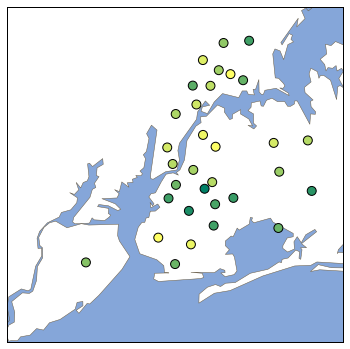

In [12]:
# Map out safety scores.
# Compute the average safety score for each district. Make a map that shows safety scores by district.

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

districts = combined.groupby(combined['school_dist']).agg(np.mean)
districts.reset_index(inplace=True)
print(districts[['school_dist', 'saf_s_11', 'lat', 'lon']].head(10))

# New York City  map info
fig, ax = plt.subplots(figsize=(10, 6))

m = Basemap(
    projection='merc', resolution='h',
    llcrnrlat=40.496044, urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, urcrnrlon=-73.700272    
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.5)
m.drawrivers(color='#6D5F47', linewidth=.5)
m.fillcontinents(color='white', lake_color='#85A6D9')

lon = districts['lon'].tolist()
lat = districts['lat'].tolist()

m.scatter(lon, lat, s=80, zorder=2, latlon=True, c=districts['saf_s_11'], cmap='summer')

plt.show()

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64


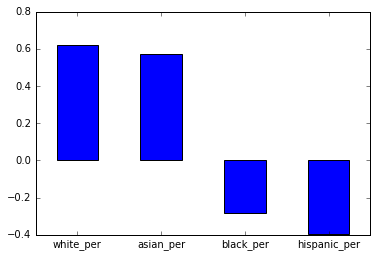

In [13]:
# Investigate racial differences in SAT scores.

correlations = combined.corr()['sat_score']
correlations = correlations[['white_per', 'asian_per', 'black_per', 'hispanic_per']]
print(correlations)

correlations.plot.bar(rot=0)
plt.show()

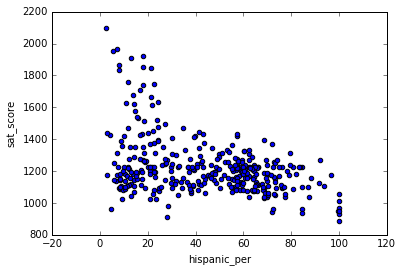

In [14]:
combined.plot.scatter(x='hispanic_per', y='sat_score')
plt.show()

In [15]:
histanic = combined[combined['hispanic_per'] > 95]
print(histanic['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [16]:
histanic = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]
print(histanic['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64


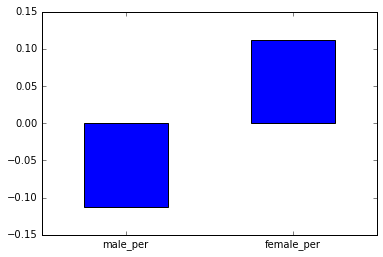

In [17]:
# Investigate gender differences in SAT scores.

correlations = combined.corr()['sat_score']
correlations = correlations[['male_per', 'female_per']]
print(correlations)

correlations.plot.bar(rot=0)
plt.show()

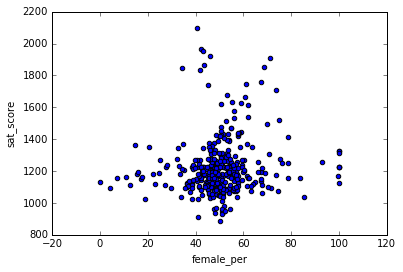

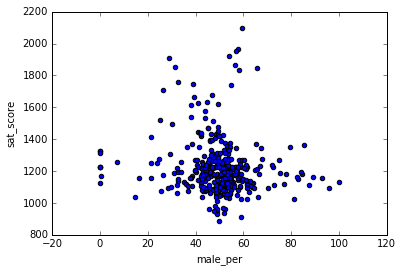

In [18]:
combined.plot.scatter(x='female_per', y='sat_score')
plt.show()

combined.plot.scatter(x='male_per', y='sat_score')
plt.show()

In [19]:
female = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
print(female['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


   sat_score    ap_per  AP Test Takers   total_enrollment
0     1122.0  0.305756       129.028846               422
1     1172.0  0.098985        39.000000               394
2     1149.0  0.031773        19.000000               598
3     1207.0  0.351577       129.028846               367
4     1621.0  0.158091       255.000000              1613
5     1856.0  0.209123       129.028846               617
6     1182.0  0.741545       129.028846               174
7     1194.0  0.297988       129.028846               433
8     1156.0  0.376177       129.028846               343
9     1111.0  0.307945       129.028846               419


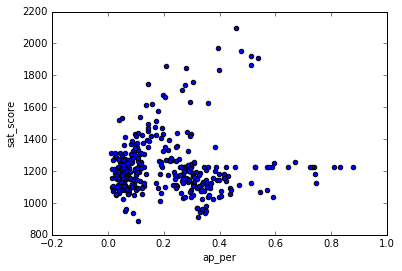

In [20]:
# Investigate the relationship between AP scores and SAT scores.

combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
print(combined[['sat_score', 'ap_per', 'AP Test Takers ', 'total_enrollment']].head(10))

combined.plot.scatter(x='ap_per', y='sat_score')
plt.show()

In [21]:
# all of combined column
combined.columns.tolist()

['DBN',
 'SCHOOL NAME',
 'Num of SAT Test Takers',
 'SAT Critical Reading Avg. Score',
 'SAT Math Avg. Score',
 'SAT Writing Avg. Score',
 'sat_score',
 'SchoolName',
 'AP Test Takers ',
 'Total Exams Taken',
 'Number of Exams with scores 3 4 or 5',
 'Demographic',
 'School Name',
 'Cohort',
 'Total Cohort',
 'Total Grads - n',
 'Total Grads - % of cohort',
 'Total Regents - n',
 'Total Regents - % of cohort',
 'Total Regents - % of grads',
 'Advanced Regents - n',
 'Advanced Regents - % of cohort',
 'Advanced Regents - % of grads',
 'Regents w/o Advanced - n',
 'Regents w/o Advanced - % of cohort',
 'Regents w/o Advanced - % of grads',
 'Local - n',
 'Local - % of cohort',
 'Local - % of grads',
 'Still Enrolled - n',
 'Still Enrolled - % of cohort',
 'Dropped Out - n',
 'Dropped Out - % of cohort',
 'CSD',
 'NUMBER OF STUDENTS / SEATS FILLED',
 'NUMBER OF SECTIONS',
 'AVERAGE CLASS SIZE',
 'SIZE OF SMALLEST CLASS',
 'SIZE OF LARGEST CLASS',
 'SCHOOLWIDE PUPIL-TEACHER RATIO',
 'Name',

correlation between class size and SAT scores : 0.38101433081


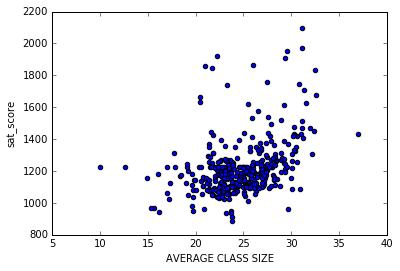

'\nMy observations :\ntotal_enrollment is highly positively correlated with sat_score --->\nAVERAGE CLASS SIZE is highly positively correlated with sat_score\n'

In [22]:
# Determing wheter there's a correlation between class size and SAT scores

correlation = combined.corr()['sat_score']
correlation = correlation['AVERAGE CLASS SIZE']
print('correlation between class size and SAT scores :', correlation)

combined.plot.scatter(x='AVERAGE CLASS SIZE', y='sat_score')
plt.show()

'''
My observations :
total_enrollment is highly positively correlated with sat_score --->
AVERAGE CLASS SIZE is highly positively correlated with sat_score
'''

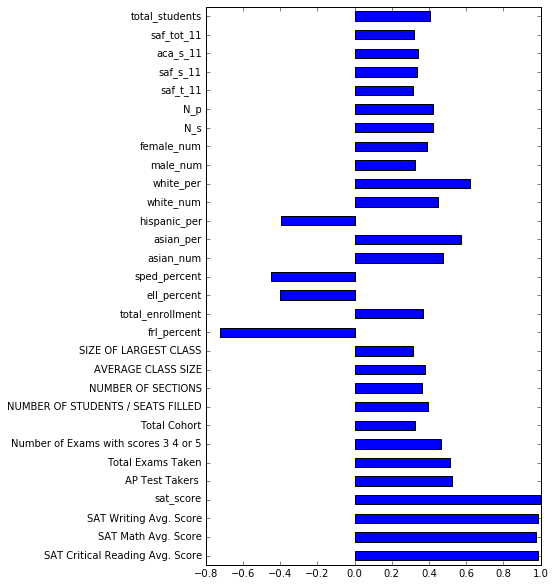

In [46]:
# observations highly correlation

correlation = combined.corr()['sat_score']
correlation = correlation[(correlation > 0.3) | (correlation < -0.3)]

ax, fig = plt.subplots(figsize=(6, 10))
correlation.plot.barh()

plt.show()

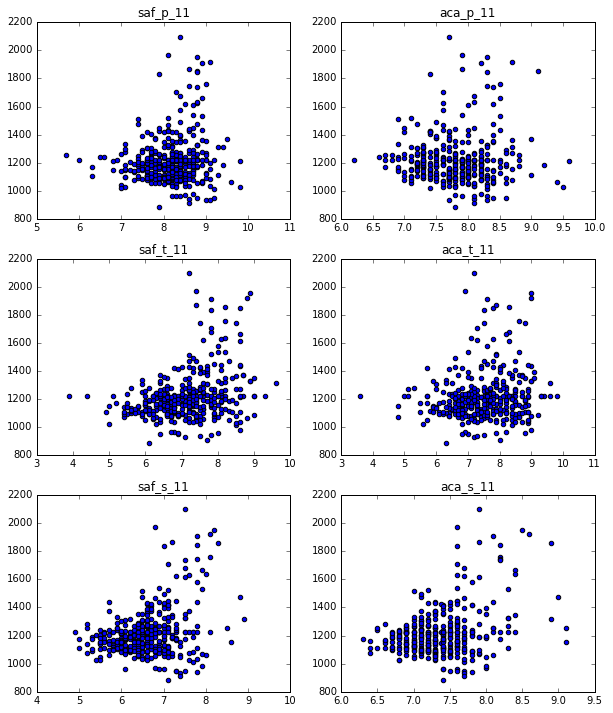

In [45]:
# Investigating the differences between parent, teacher, and student responses to surveys.

surveys_list = ['saf_p_11', 'aca_p_11', 'saf_t_11', 'aca_t_11', 'saf_s_11', 'aca_s_11']
fig = plt.figure(figsize=(10, 12))

for i, surveys in enumerate(surveys_list) :
    ax = fig.add_subplot(3, 2, i+1)
    ax.scatter(combined[surveys], combined['sat_score'])
    ax.set_title(surveys)
    
plt.show()